In [68]:
from utils import make_need_tree,visualize_tree,make_storage,make_task_dict
from tqdm import tqdm
from colors import colors

In [69]:
storage = make_storage()
storage['fishing net']=20
storage['apple']=20
storage['wool']=20
storage['fish fillet']=100
orders = [
            *['cream']*4,
            *['cheese']*1,
        ]

orders = [
*['milk']*4,
*['bread']*15,
*['bacon and eggs']*2,
*['corn bread']*4,
*['cheesecake']*3,
*['apple pie']*3,
]

In [70]:
task_dict=make_task_dict(orders,storage)
set(task['source'] for task in task_dict.values()),len(task_dict)

({'BBQ Grill',
  'Bakery',
  'Cake Oven',
  'Chicken',
  'Cow',
  'Dairy',
  'Feed Mill',
  'Field',
  'Pie Oven',
  'Pig',
  'Sugar Mill'},
 279)

In [71]:
machines={'Bakery':1, 'Cow':3, 'Feed Mill':1, 'Field':4,'Dairy':1,'Chicken':3,'Sugar Mill':1,
        'Pig':3,'Pie Oven':1,'Cake Oven':1,'BBQ Grill':1}

In [72]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns


In [73]:
# generate chromosome
def generate_chromosome(task_dict):
    """
    Generate a chromosome for the genetic algorithm.

    Parameters:
    - task_dict (dict): A dictionary containing task information.

    Returns:
    - chromosome (numpy.ndarray): A 2xlength matrix with integer values.
                                  The first row represents the task IDs,
                                  and the second row represents the machine IDs.
    """
    chromosome = np.zeros((2,len(task_dict))).astype(int)
    tasks = list(task_dict.values())
    random.shuffle(tasks)
    tasks.sort(key=lambda x:x['depth'],reverse=True)
    for i in range(len(tasks)):
        chromosome[0][i]=tasks[i]['id']
        chromosome[1][i]=random.randint(1,machines[tasks[i]['source']])
    return chromosome

In [74]:
def calc_start_end_time(chromosome):
  """
  Calculates the start and end time for each task in the chromosome.

  Args:
    chromosome (tuple): A tuple containing two lists - the first list represents the task IDs and the second list represents the machine IDs.

  Returns:
    dict: A dictionary containing the start and end time for each task.
  """
  machine_queue_dict = {}
  for machine_name in machines.keys():
    machine_queue_dict[machine_name] = {}
    for count in range(1, machines[machine_name] + 1):
      machine_queue_dict[machine_name][count] = []
  temp_task_dict = {}
  for i in range(len(chromosome[0])):
    task_id = chromosome[0][i]
    machine_id = chromosome[1][i]
    task = task_dict[task_id]
    machine_name = task['source']
    machine = machine_queue_dict[machine_name][machine_id]
    temp_task = task.copy()
    temp_task['start_time'] = 0
    temp_task['end_time'] = task['duration']
    temp_task['machine_id'] = machine_id
    if len(machine) > 0:
      last_task_id = machine[-1]
      last_task = temp_task_dict[last_task_id]
      temp_task['start_time'] = last_task['end_time']
      temp_task['end_time'] = temp_task['start_time'] + task['duration']
    for depend_task_id in task['dependencies']:
      depend_task = temp_task_dict[depend_task_id]
      if depend_task['end_time'] > temp_task['start_time']:
        temp_task['start_time'] = depend_task['end_time']
        temp_task['end_time'] = temp_task['start_time'] + task['duration']
    temp_task_dict[task_id] = temp_task
    machine.append(task_id)
  return temp_task_dict

def fitness(chromosome):
  """
  Calculate the fitness of a chromosome.

  Parameters:
  chromosome (list): The chromosome representing a solution.

  Returns:
  int: The fitness value of the chromosome.
  """
  task_dict = calc_start_end_time(chromosome)
  max_end_time = max(task['end_time'] for task in task_dict.values())
  return 60*60*24/max_end_time

In [75]:
def plot_chromosome(chromosome,show_text=False):
    """
    Plots the timeline of tasks based on the given chromosome.

    Parameters:
    chromosome (list): The chromosome representing the tasks.

    Returns:
    matplotlib.figure.Figure: The generated figure object.
    """
    test_tasks = calc_start_end_time(chromosome)
    df = pd.DataFrame(test_tasks.values())
    # task is source + machine_id
    df['task'] = df['source'] + ' ' + df['machine_id'].astype(str)
    # sort by task
    df = df.sort_values('task', ascending=False)
    fig, ax = plt.subplots(figsize=(20, 10))
    for i in range(len(df)):
        row = df.iloc[i]
        color = colors[row['root_id'] % len(colors)]  # Get color from the colors list
        ax.barh(row['task'], row['duration'], left=row['start_time'], edgecolor='black', color=color)  # Add edgecolor to create a border
        if show_text:
            ax.text(row['start_time'] + row['duration'] / 2, row['task'], row['name'],        ha='center', va='center', rotation=90)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Task')
    ax.set_title('Timeline of Tasks')
    # legend is root_id. example: task 1,task 2
    legend_elements = []
    for root_id in df['root_id'].unique():
        legend_elements.append(Line2D([0], [0], color=colors[root_id % len(colors)], lw=4, label=f'Task {root_id}'))  # Get color from the colors list
    ax.legend(handles=legend_elements, loc='upper right', title='Task')
    return fig


In [76]:
# Selection function
def select(population, fitnesses):
    total_fitness = sum(fitnesses)
    probabilities = [f / total_fitness for f in fitnesses]
    parent1, parent2 = random.choices(population, weights=probabilities, k=2)
    return parent1, parent2

In [77]:
def crossover(parent1, parent2):
    if random.random() > 0.8:
        parent1 = parent1.copy()
        parent2 = parent2.copy()
        return parent1, parent2
    row, size = parent1.shape   
    # Randomly select a crossover range
    start = random.randint(0, size - 1)
    end = random.randint(start+1, size )
    # Initialize offspring with empty values
    offspring1 = np.zeros((row, size), dtype=int)
    offspring2 = np.zeros((row, size), dtype=int)
    offspring1[:, start:end] = parent2[:, start:end]
    offspring2[:, start:end] = parent1[:, start:end]

    ids1 = [i for i in parent1.T if i[0] not in offspring1[0]]
    ids2 = [i for i in parent2.T if i[0] not in offspring2[0]]
    for i in range(size):
        if offspring1[0][i]==0:
            offspring1[0][i]=ids1[0][0]
            offspring1[1][i]=ids1[0][1]
            ids1.pop(0)
        if offspring2[0][i]==0:
            offspring2[0][i]=ids2[0][0]
            offspring2[1][i]=ids2[0][1]
            ids2.pop(0)
    return offspring1, offspring2



In [78]:
def mutate(chromosome):
    for idx in range(len(chromosome[0])):
        if random.random() < 0.2:
            task = task_dict[chromosome[0][idx]]
            chromosome[1][idx]=random.randint(1,machines[task['source']])

In [79]:
# Example of using these functions in a genetic algorithm
def genetic_algorithm(pop_size,iteration):
    # Initialize a random population
    population = [generate_chromosome(task_dict) for _ in range(pop_size)]
    for iter in range(iteration):
        new_population = []
        fitnesses = [fitness(chromosome) for chromosome in population]
        best_chromosome = population[np.argmax(fitnesses)]
        temp=calc_start_end_time(best_chromosome)
        print(f"Generation {iter+1} best fitness: {max(fitnesses)}, makespan: {max(task['end_time'] for task in temp.values())}")
        new_population.append(best_chromosome)        
        for _ in range(pop_size // 2):
            parent1, parent2 = select(population, fitnesses)
            offspring1, offspring2 = crossover(parent1, parent2)
            mutate(offspring1)
            mutate(offspring2)
            new_population.append(offspring1)
            new_population.append(offspring2)
        population = new_population[:pop_size]
    fitnesses = [fitness(chromosome) for chromosome in population]
    best_fitness = max(fitnesses)
    best_index = fitnesses.index(best_fitness)
    best_chromosome = population[best_index]
    return best_chromosome

In [80]:
65940

65940

In [83]:
best_chromosome = genetic_algorithm(pop_size=100,iteration=200)

Generation 1 best fitness: 1.2318220701454234, makespan: 70140
Generation 2 best fitness: 1.2489158716392021, makespan: 69180
Generation 3 best fitness: 1.2489158716392021, makespan: 69180
Generation 4 best fitness: 1.2489158716392021, makespan: 69180
Generation 5 best fitness: 1.2903225806451613, makespan: 66960
Generation 6 best fitness: 1.2903225806451613, makespan: 66960
Generation 7 best fitness: 1.2903225806451613, makespan: 66960
Generation 8 best fitness: 1.2903225806451613, makespan: 66960
Generation 9 best fitness: 1.2914798206278026, makespan: 66900
Generation 10 best fitness: 1.342031686859273, makespan: 64380
Generation 11 best fitness: 1.342031686859273, makespan: 64380
Generation 12 best fitness: 1.354656632173095, makespan: 63780
Generation 13 best fitness: 1.354656632173095, makespan: 63780
Generation 14 best fitness: 1.354656632173095, makespan: 63780
Generation 15 best fitness: 1.354656632173095, makespan: 63780
Generation 16 best fitness: 1.354656632173095, makespan

In [ ]:
62820

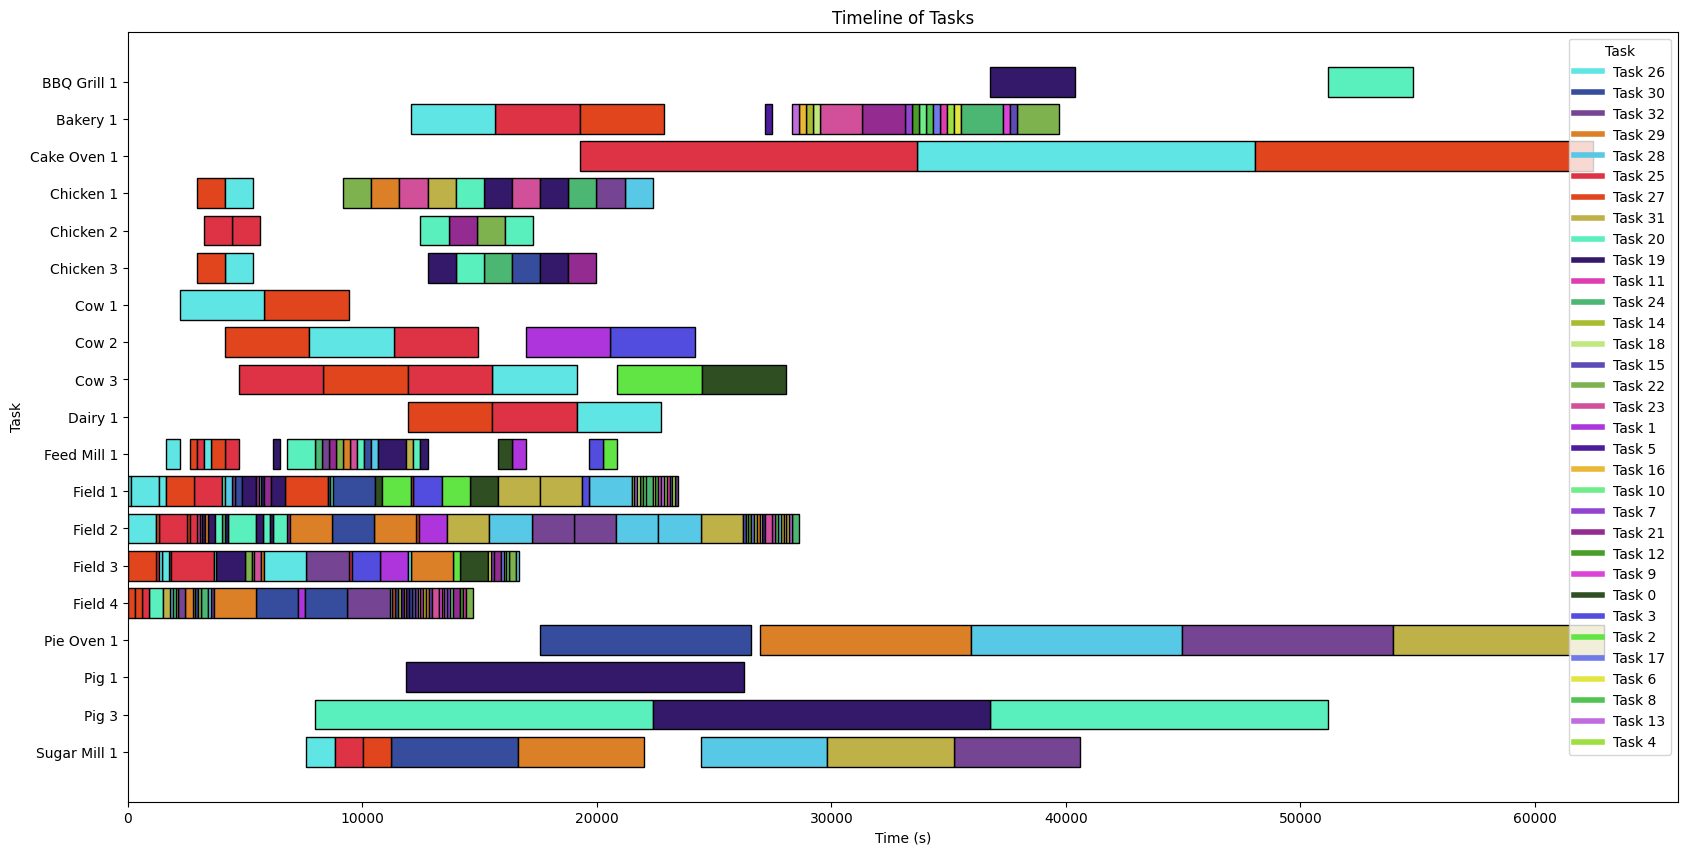

In [82]:
plot_chromosome(best_chromosome,show_text=False)
plt.show()